In [33]:
from typing import List, Optional
from typing_extensions import TypedDict

# 장소 정보를 담는 TypedDict 정의
class KakaoPlace(TypedDict):
    name: str
    address: str
    url: str

In [ ]:
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from typing import Annotated

# 대화 상태를 담는 TypedDict 정의
class State(TypedDict):
    '''search_answer 는 extract_keywords 함수에서 추출된 검색어를 담는 필드입니다.'''
    messages: Annotated[List[BaseMessage], add_messages]
    # search_query: Optional[str]
    search_query: Optional[str] 
    search_answer: Optional[str]
    search_results: Optional[List[KakaoPlace]]

In [35]:
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(model="gpt-4o-mini")

In [36]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage

# 키워드 추출 도구 함수 정의
@tool
def extract_keyword(user_request: str) -> str:
    """사용자 요청에서 장소 검색을 위한 짧고 명확한 키워드를 추출합니다."""
    prompt = (
        "다음 요청에서 장소 검색에 사용할 키워드를 한 문장으로 추출해줘.\n"
        "- 키워드는 띄어쓰기로 구분된 한 문장이어야 해.\n"
        "- 다른 설명은 하지 말고 키워드만 알려줘.\n\n"
        f"요청: '{user_request}'"
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    keyword = response.content.strip().strip('"').strip("'")
    return keyword

In [37]:
import requests
@tool
def kakao_place_search(query: str) -> list[KakaoPlace]:
    """카카오 장소 검색 API를 사용하여 장소를 검색합니다."""
    url = "https://dapi.kakao.com/v2/local/search/keyword.json"
    headers = {"Authorization": f"KakaoAK {os.getenv('KAKAO_API_KEY')}"}
    params = {"query": query, "size": 5}
    response = requests.get(url, headers=headers, params=params)
    data = response.json().get("documents", [])
    results: list[KakaoPlace] = []
    for place in data:
        results.append({
            "name": place.get("place_name", ""),
            "address": place.get("address_name", ""),
            "url": place.get("place_url", "")
        })
    return results

In [38]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

def chatbot_node(state: State):
    ai_response = llm_with_tools.invoke(state["messages"])
    return {"messages": [ai_response]}

tools = [extract_keyword, kakao_place_search]
llm_with_tools = llm.bind_tools(tools)
tool_node = ToolNode(tools)
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

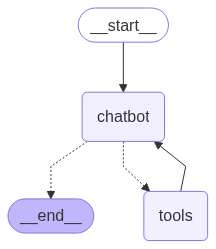

In [39]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
from langchain_core.messages import HumanMessage
# 초기 상태 설정: 사용자 질문 입력
initial_state: State = {
    "messages": [HumanMessage(content="대전을 대표하는 빵집은?")],
    "search_query": None,
    "search_results": None
}
# 그래프 실행하여 결과 얻기
final_state = graph.invoke(initial_state)

In [41]:
from langchain_core.messages import AIMessage, ToolMessage
for msg in final_state["messages"]:
    if isinstance(msg, HumanMessage):
        print("👤 사용자:", msg.content)
    elif isinstance(msg, AIMessage):
        print("🤖 챗봇:", msg.content)
        if msg.tool_calls:
            for call in msg.tool_calls:
                print(f"  ↪ (도구 요청: {call['name']} {call['args']})")
    elif isinstance(msg, ToolMessage):
        print(f"🔧 도구[{msg.name}] 결과:", msg.content)

👤 사용자: 대전을 대표하는 빵집은?
🤖 챗봇: 
  ↪ (도구 요청: extract_keyword {'user_request': '대전을 대표하는 빵집은?'})
🔧 도구[extract_keyword] 결과: 대전 빵집
🤖 챗봇: 
  ↪ (도구 요청: kakao_place_search {'query': '대전 빵집'})
🔧 도구[kakao_place_search] 결과: [{"name": "성심당 본점", "address": "대전 중구 은행동 145-1", "url": "http://place.map.kakao.com/17733090"}, {"name": "성심당 대전역점", "address": "대전 동구 정동 1-1", "url": "http://place.map.kakao.com/21537026"}, {"name": "달달빵집", "address": "대전 중구 목동 111-12", "url": "http://place.map.kakao.com/1063471907"}, {"name": "성심당 롯데백화점 대전점", "address": "대전 서구 괴정동 423-1", "url": "http://place.map.kakao.com/1513470800"}, {"name": "내가만든미케익 대전점", "address": "대전 중구 은행동 52-10", "url": "http://place.map.kakao.com/10184597"}]
🤖 챗봇: 대전을 대표하는 빵집으로는 다음과 같은 곳들이 있습니다:

1. **성심당 본점**
   - 주소: 대전 중구 은행동 145-1
   - [지도 보기](http://place.map.kakao.com/17733090)

2. **성심당 대전역점**
   - 주소: 대전 동구 정동 1-1
   - [지도 보기](http://place.map.kakao.com/21537026)

3. **달달빵집**
   - 주소: 대전 중구 목동 111-12
   - [지도 보기](http://place.map.kakao.com/1

In [42]:
# 추가 테스트 예시
initial_state["messages"] = [HumanMessage(content="서울에서 애견동반 가능한 카페 알려줘")]
final_state = graph.invoke(initial_state)
for msg in final_state["messages"]:
    if isinstance(msg, HumanMessage):
        print("👤 사용자:", msg.content)
    elif isinstance(msg, AIMessage):
        print("🤖 챗봇:", msg.content)
        if msg.tool_calls:
            for call in msg.tool_calls:
                print(f"  ↪ (도구 요청: {call['name']} {call['args']})")
    elif isinstance(msg, ToolMessage):
        print(f"🔧 도구[{msg.name}] 결과:", msg.content)

👤 사용자: 서울에서 애견동반 가능한 카페 알려줘
🤖 챗봇: 
  ↪ (도구 요청: extract_keyword {'user_request': '서울에서 애견동반 가능한 카페 알려줘'})
🔧 도구[extract_keyword] 결과: 서울 애견동반 카페
🤖 챗봇: 
  ↪ (도구 요청: kakao_place_search {'query': '서울 애견동반 카페'})
🔧 도구[kakao_place_search] 결과: [{"name": "프리츠 도화점", "address": "서울 마포구 도화동 179-9", "url": "http://place.map.kakao.com/24529429"}, {"name": "꽁티드툴레아 도산점", "address": "서울 강남구 신사동 646-21", "url": "http://place.map.kakao.com/179244712"}, {"name": "마일스톤커피", "address": "서울 강남구 신사동 554-4", "url": "http://place.map.kakao.com/22549791"}, {"name": "앤트러사이트 한남점", "address": "서울 용산구 한남동 683-142", "url": "http://place.map.kakao.com/27344582"}, {"name": "카페1953위드오드리", "address": "서울 영등포구 문래동2가 34-10", "url": "http://place.map.kakao.com/339122660"}]
🤖 챗봇: 서울에서 애견동반 가능한 카페 몇 곳을 소개합니다:

1. [프리츠 도화점](http://place.map.kakao.com/24529429)
   - 주소: 서울 마포구 도화동 179-9

2. [꽁티드툴레아 도산점](http://place.map.kakao.com/179244712)
   - 주소: 서울 강남구 신사동 646-21

3. [마일스톤커피](http://place.map.kakao.com/22549791)
   - 주소: 서울 강남